## Machine Learning: bikeshare data for Capstone 1

### Build a model

- Predict demand (# of rentals) on a given day (e.g. for 2017) 
    - linear regression/SVM
    - X: julian day; y: count/day
    - could add X: proximity to metro station <-- but is this redundant with station? could use for interpretation

#### Model steps: 
  - We can use older data to train (e.g. 2015-2016) and the most recent year to test accuracy (2017)
      - typical cross validation techniques will lead to spurious scoring becuase we are working with time series data
  - initialize a model (e.g. linear regression) and fit with training data
  - compare accuracy to test data visually

In [2]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

In [84]:
totals = pd.read_csv('../CapstoneDrafts/data/2015_16totals.csv', 
                        parse_dates=True, index_col=4)
totals.head()

,Unnamed: 0,Year,Month,Day,timeDelt,startweekday,totalRents,timeDelt_sq,holiday,date,...,tmax_sq,tmin_sq,startdate2,day_0,day_1,day_2,day_3,day_4,day_5,day_6
startdate,,,,,,,,,,,,,,,,,,,,,
2015-01-01,0,2015,1,1,0,3,2578,0,0.0,NaN,...,1296.0,484.0,2015-01-01,0,0,0,1,0,0,0
2015-01-02,1,2015,1,2,1,4,5108,1,0.0,NaN,...,1936.0,729.0,2015-01-02,0,0,0,0,1,0,0
2015-01-03,2,2015,1,3,2,5,1703,4,0.0,NaN,...,2209.0,841.0,2015-01-03,0,0,0,0,0,1,0
2015-01-04,3,2015,1,4,3,6,3658,9,0.0,NaN,...,3136.0,961.0,2015-01-04,0,0,0,0,0,0,1
2015-01-05,4,2015,1,5,4,0,5222,16,0.0,NaN,...,4356.0,1600.0,2015-01-05,1,0,0,0,0,0,0


In [86]:
#eliminate extraneous columns before proceeding
X_main=totals.drop(['totalRents','date','station','startdate2'], axis=1)
y = totals['totalRents']

Attempt 3 increasingly complex models with basic linear model:

__Model 1__: Time and time<sup>2</sup> (_2 features_)

In [87]:
X1 = totals[['timeDelt', 'timeDelt_sq']]
y = totals['totalRents']

In [88]:
lr1 = LinearRegression(normalize=True)
lr1.fit(X1, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

In [89]:
scores1 = cross_val_score(lr1, X1, y, cv=5, scoring='r2')
print('r2 scores:', scores1)
print('mean r2:',np.mean(scores1))

r2 scores: [ 0.57573812  0.0739154   0.27376097  0.17617803  0.56549251]
mean r2: 0.333017004876


This model including only the day of the year and the day of the year squared explains 22% of the variation in daily rentals. 

__Model 2__: Time, time<sup>2</sup>, daily max temp, and daily min temp, and min/max temp squared (_6 features_)

In [90]:
# model with daily mininum and maximum temperatures 
X2 = totals[['timeDelt', 'timeDelt_sq','tmax', 'tmin','tmax_sq','tmin_sq']]

In [91]:
lr2 = LinearRegression(normalize=True)
lr2.fit(X2, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

In [92]:
scores2 = cross_val_score(lr2, X2, y, cv=5, scoring='r2')
print('r2 scores:', scores2)
print('mean r2:',np.mean(scores2))

r2 scores: [ 0.69319885  0.17274234  0.39186871  0.25500755  0.57522664]
mean r2: 0.41760881828


This model also includes daily maximum and minimum temperature, and seems to only explain 21% of the variance.

__Model 3__: Time, time<sup>2</sup>, daily max temp, daily min temp, square of daily min/max temp, day of the week (7 dummy variables), holiday indicator (_14 features_)

In [93]:
## model with daily mininum and maximum temperatures, weekday dummies, and holiday indicator
X3 = totals[['timeDelt', 'timeDelt_sq','tmax', 'tmin','tmax_sq','tmax_sq',
             'day_0','day_1','day_2','day_3','day_4','day_5','holiday']]

In [94]:
lr3 = LinearRegression(normalize=True)
lr3.fit(X3, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

In [95]:
scores3 = cross_val_score(lr3, X3, y, cv=5, scoring='r2')
print('r2 scores:', scores3)
print('mean r2:', np.mean(scores3))

r2 scores: [ 0.63681648  0.17769881  0.39476093  0.32754436  0.58691737]
mean r2: 0.424747590337


This final model that includes the day of the week and holiday indicator seems to be the worst predictor of daily totals only explaining 13% of the variance. 

#### Model comparison and predictions
After calling ```.predict``` on the three models above, let's plot the actual 2016 and the predicted values from the models.

In [96]:
#predictions
totals['predicted1'] = lr1.predict(X1)
totals['predicted2'] = lr2.predict(X2)
totals['predicted3'] = lr3.predict(X3)

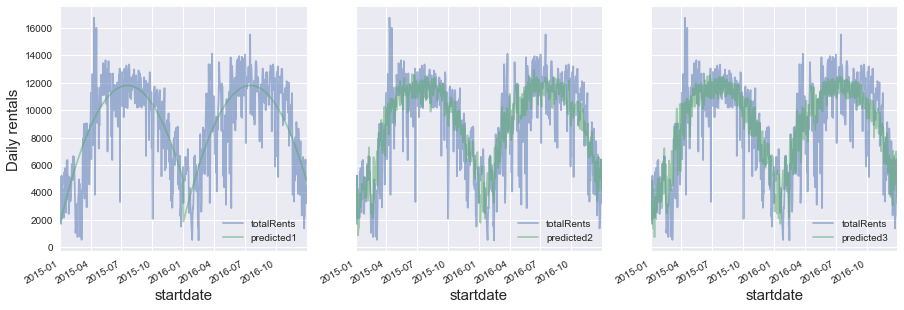

In [97]:
#predicted vs. actual plots
fig, axes = plt.subplots(1,3, sharey=True)
fig.set_size_inches(15,5)
axes[0].set_ylabel('Daily rentals',fontsize=15)
axes[0].set_xlabel('Day of the year (1 to 365)',fontsize=15)
axes[1].set_xlabel('Day of the year (1 to 365)',fontsize=15)
axes[2].set_xlabel('Day of the year (1 to 365)',fontsize=15)
totals[['totalRents', 'predicted1']].plot(alpha=0.5, ax=axes[0])
totals[['totalRents', 'predicted2']].plot(alpha=0.5, ax=axes[1])
totals[['totalRents', 'predicted3']].plot(alpha=0.5, ax=axes[2])

In [98]:
params = pd.Series(lr3.coef_, index=X3.columns)
params

timeDelt         66.835891
timeDelt_sq      -0.171764
tmax            216.940425
tmin            -38.058270
tmax_sq          -0.469578
tmax_sq          -0.469578
day_0           492.972600
day_1           888.320502
day_2          1176.635104
day_3           848.410729
day_4          1132.439418
day_5           339.742751
holiday           0.000000
dtype: float64

Attempt Ridge Regression:

In [99]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV

ridge_cv = RidgeCV(normalize=True, store_cv_values=True)

In [100]:
ridge_cv

RidgeCV(alphas=(0.1, 1.0, 10.0), cv=None, fit_intercept=True, gcv_mode=None,
    normalize=True, scoring=None, store_cv_values=True)

In [101]:
ridge_cv.fit(X3, y)

RidgeCV(alphas=(0.1, 1.0, 10.0), cv=None, fit_intercept=True, gcv_mode=None,
    normalize=True, scoring=None, store_cv_values=True)

In [102]:
ridge_cv.alpha_

0.10000000000000001

In [103]:
ridge_cv.score(X3, y)

0.59161017276053496

In [104]:
params_ridge = pd.Series(ridge_cv.coef_, index=X3.columns)
params_ridge

timeDelt         6.285901
timeDelt_sq     -0.015945
tmax            59.239059
tmin            21.758126
tmax_sq          0.178681
tmax_sq          0.178681
day_0          233.391507
day_1          539.850543
day_2          776.795556
day_3          502.513491
day_4          741.595786
day_5           29.205507
holiday          0.000000
dtype: float64

In [105]:
totals['predicted_ridge'] = ridge_cv.predict(X3)

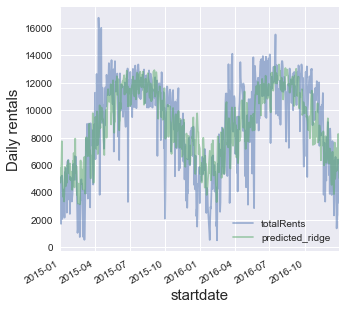

In [106]:
#predicted vs. actual plots
fig, ax = plt.subplots(1,1)
fig.set_size_inches(5,5)
ax.set_ylabel('Daily rentals',fontsize=15)
ax.set_xlabel('Day of the year (1 to 365)',fontsize=15)
totals[['totalRents', 'predicted_ridge']].plot(alpha=0.5, ax=ax)
